In [4]:
import pandas as pd  # Добавляем импорт Pandas
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 1. Загрузка данных

In [ ]:
# Модификации датасета:
# df_entire - датасет целиком AS IS на сейте
# df_encoded - датасет после применения LabelEncoder и преобразования InvoiceDate из типа 'object' в 'datetime64'
# df_no_missing - датасет с офильтрованныи пропусками в поле CustomerID - их не логично заполнять средним или мединным значением,
#                но можно не убирать при агрегированном среднесуточном анализе без разбивки по клиентам.
# df_next - датасет после выбора пользователем, сохранить или оставить покупателей без CustomerID
# df_sales - датасет только по продажам (без возвратов)
# df_sales_clean - датасет после очистки ошибок данных
# df_invoice_features - датасет дополнен фичами для каждого чека на основе группировки по InvoiceNo
# df_customer_features - датасет дополнен фичами для каждого покупателя на основе группировки по CustomerID
# df_date_features - датасет дополнен фичами для каждого дня на основе группировки по Date

In [16]:
# Импортируем функции для загрузки данных
from Modules.data_loader import data_load

# Загрузка данных
df_entire = data_load()

if df_entire is None:
    print("\nОшибка: данные не загружены.")


Откуда вы хотите загрузить данные?
    Предпочтительнее загрузка данных из архива, т.к. на сайте отсутствуют поля ['InvoiceNo', 'StockCode'].
    Введите 'site' для загрузки с сайта или 'zip' для загрузки из архива:zip
Данные загружены из файла: /content/DS_Project/HW_5/Modules/../Data/online_retail_csv.csv


In [ ]:
# 2. EDA анализ

In [17]:
# 2.1 Первичный просмотр датасета: поля, типы данных, статисический срез

# Импортируем функции для выполнения EDA
from Modules.eda import perform_eda, analyze_missing_values, analyze_returns, print_comparison_results

perform_eda(df_entire)


**Поля и типы данных:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

**Первые строки данных:**

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATE

In [18]:
# 2.2 Энкодирование категориальных переменных

# Импортируем функции для предварительной обработки
from Modules.preprocessing import preprocess_data

# Метод так же создает индекс CustomerID_missing, помечающий пропуски в CustomerID
df_encoded, label_encoders = preprocess_data(df_entire)


Трансформация данных и энкодирование категориальных переменных завершены. Файл сохранен в /content/DS_Project/HW_5/Data/label_encodings.txt.


In [19]:
# 2.3 Анализ пропущенных значений в CustomerID
analyze_missing_values(df_encoded)  # Явно передаем df_encoded и df_no_missing

print(f"""
Пропуски в поле CustomerID не логично заполнять средним или медианным значением - это может создать покупателя с аномальным поведением.
Для дальнейшей работы с агрегированными данными (прогноз всех покупок на дату) пропуски можно не убирать и отправлять в методы датасет df_entire.
Для прогноза по покупателям в анализ следует отправлять очищенный от пропусков датасет df_no_missing.""")

# Создание df_no_missing - датасета с отфильтрованными пропусками в поле CustomerID
df_no_missing = df_encoded[df_encoded['CustomerID_missing'] == 0]


Анализ данных без пропусков в CustomerID:
Количество строк в df_no_missing: 406829

**Поля и типы данных:**

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           406829 non-null  object        
 1   StockCode           406829 non-null  object        
 2   Description         406829 non-null  int64         
 3   Quantity            406829 non-null  int64         
 4   InvoiceDate         406829 non-null  datetime64[ns]
 5   UnitPrice           406829 non-null  float64       
 6   CustomerID          406829 non-null  int64         
 7   Country             406829 non-null  int64         
 8   CustomerID_missing  406829 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 31.0+ MB
None

**Первые строки данных:**

  InvoiceNo StockCode  Description  Quantit

In [21]:
# Запрос у пользователя, стоит ли сохранять пропущенные CustomerID

missing_customer = input(f"""
Хотите сохранить клиентов без указанного CustomerID для дальнейшей обработки?
Введите 'y' для сохранения их в обработке или 'n' для исключения:
""")

if missing_customer.lower() == 'n':
    df_next = df_no_missing
    print("Покупатели без CustomerID исключены из дальнейшей обработки.")
elif missing_customer.lower() == 'y':
    df_next = df_encoded
    print("Покупатели без CustomerID сохранены в дальнейшей обработки.")
else:
    print("Ошибка: некорректный выбор. По умолчанию клиенты без указанного CustomerID исключены из дальнейшей обработки.")
    df_next = df_no_missing


Хотите сохранить клиентов без указанного CustomerID для дальнейшей обработки?
Введите 'y' для сохранения их в обработке или 'n' для исключения:
y
Покупатели без CustomerID сохранены в дальнейшей обработки.


In [22]:
# 2.4 Анализ доли возвратов в датасете

print("Анализ доли возвратов:\n")
df_sales = analyze_returns(df_next)

print("\nПродолжаем работу с данными продаж (без возвратов)")

Анализ доли возвратов:

Столбец IsReturn добавлен:
  InvoiceNo StockCode  Description  Quantity         InvoiceDate  UnitPrice  \
0    536365    85123A         3918         6 2010-12-01 08:26:00       2.55   
1    536365     71053         3926         6 2010-12-01 08:26:00       3.39   
2    536365    84406B          913         8 2010-12-01 08:26:00       2.75   
3    536365    84029G         1910         6 2010-12-01 08:26:00       3.39   
4    536365    84029E         2911         6 2010-12-01 08:26:00       3.39   

   CustomerID  Country  CustomerID_missing  IsReturn  
0        4049       36                   0     False  
1        4049       36                   0     False  
2        4049       36                   0     False  
3        4049       36                   0     False  
4        4049       36                   0     False  
Количество возвратов: 9288
Сумма возвратов: -896812.49
Количество продаж: 532621
Сумма продаж: 10644560.42
Процент возвратов по количеству: 1.71

In [ ]:
# 3. Очистка данных

In [23]:
# Импортируем функции из модуля preprocessing
from Modules.preprocessing import clean_data

# Очистка данных
df_sales_clean = clean_data(df_sales)


Общее количество товаров до очистки: 5454024
Общая сумма продаж до очистки: 10644560.42

Инвойсы с отрицательными значениями Quantity:
['536589' '536764' '536996' ... '581213' '581226' '581422']
Количество удаленных инвойсов: 1336
Количество удаленых товаров: 206957
Доля от общего количества товаров: 3.79%
Сумма удаленых продаж: 0.00
Доля от общей суммы продаж: 0.00%

Инвойсы с отрицательными значениями UnitPrice:
['A563186' 'A563187']
Количество удаленных инвойсов: 2
Количество удаленых товаров: 2
Доля от общего количества товаров: 0.00%
Сумма удаленых продаж: 22124.12
Доля от общей суммы продаж: 0.21%

Инвойсы, не соответствующие условию 'a 6-digit integral number':
['A563185']
Количество удаленных инвойсов: 1
Количество удаленых товаров: 1
Доля от общего количества товаров: 0.00%
Сумма удаленых продаж: 11062.06
Доля от общей суммы продаж: 0.10%

Инвойсы с разными InvoiceDate или CustomerID для одного InvoiceNo:
['536591' '540185' '541596' '541631' '541809' '541816' '541849' '542217

In [ ]:
# 4. Создание фичей

In [24]:
# Импортируем функции из модуля feature_engineering
from Modules.feature_engineering import create_invoice_features, create_customer_features, create_date_features, normalize_features

# Создание фичей для каждого чека
df_invoice_features = create_invoice_features(df_sales_clean)

print("Фичи для каждого чека:\n", df_invoice_features.head())

print("Статистика:\n", df_invoice_features.describe())

Фичи для каждого чека:
   InvoiceNo  TotalAmount  MinUnitPrice  MaxUnitPrice  MedianUnitPrice  \
0    536365       139.12          2.55          7.65             3.39   
1    536366        22.20          1.85          1.85             1.85   
2    536367       278.73          1.65          9.95             4.60   
3    536368        70.05          4.25          4.95             4.95   
4    536369        17.85          5.95          5.95             5.95   

   MinQuantity  MaxQuantity  TotalQuantity         InvoiceDate  CustomerID  
0            2            8             40 2010-12-01 08:26:00        4049  
1            6            6             12 2010-12-01 08:28:00        4049  
2            2           32             83 2010-12-01 08:34:00         541  
3            3            6             15 2010-12-01 08:34:00         541  
4            3            3              3 2010-12-01 08:35:00         541  
Статистика:
          TotalAmount  MinUnitPrice  MaxUnitPrice  MedianUnitPr

In [25]:
# Создание фичей для каждого абонента
df_customer_features = create_customer_features(df_invoice_features)

print("Фичи для каждого абонента:\n", df_customer_features.head())

print("Статистика:\n", df_customer_features.describe())

Фичи для каждого абонента:
    CustomerID   FirstPurchaseDate    LastPurchaseDate  TotalPurchaseCount  \
0           0 2010-12-01 11:52:00 2011-12-09 10:26:00                2177   
1           1 2011-01-18 10:01:00 2011-01-18 10:01:00                   1   
2           2 2010-12-07 14:57:00 2011-12-07 15:52:00                   7   
3           3 2010-12-16 19:09:00 2011-09-25 13:13:00                   4   
4           4 2011-11-21 09:51:00 2011-11-21 09:51:00                   1   

   TotalPurchaseAmount  AveragePurchaseAmount  TotalQuantity  \
0           1700784.30             781.251401         467707   
1             77183.60           77183.600000          74215   
2              4310.00             615.714286           2458   
3              1797.24             449.310000           2341   
4              1757.55            1757.550000            631   

   DaysSinceFirstPurchase  LastMonthPurchaseAmount  
0                     373                374822.67  
1                 

In [26]:
# Создание фичей на основе группировки по дате
df_date_features = create_date_features(df_sales_clean)

print("Фичи на основе группировки по дате:\n", df_date_features.head())

print("Статистика:\n", df_date_features.describe())

Фичи на основе группировки по дате:
          Date  TotalSalesAmount  TotalSalesQuantity  AverageSalesAmount  \
0  2010-12-01          58762.47               26914           19.323403   
1  2010-12-02          47748.38               31348           23.133905   
2  2010-12-03          46943.71               16471           21.733199   
3  2010-12-05          31774.95               16451           11.729402   
4  2010-12-06          54830.46               21951           14.346013   

   AverageSalesQuantity  NumberOfTransactions  DayOfWeek  WeekOfYear  \
0              8.850378                   135          2          48   
1             15.187984                   143          3          48   
2              7.625463                    73          4          48   
3              6.072721                    88          6          48   
4              5.743328                   108          0          49   

   MonthOfYear  
0           12  
1           12  
2           12  
3          

In [ ]:
# 5. Визуализация данных

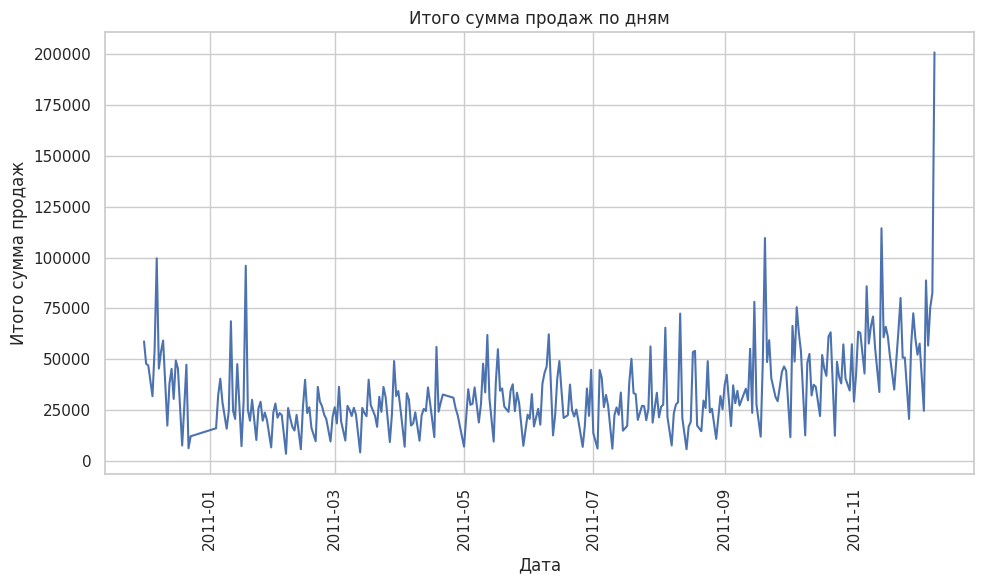

Сумма продаж имеет тренд на увеличение к концу 2011г.
Скорее всего в конце декабря 2010 начале января 2011 пропущено несколько дней


In [27]:
# Импортируем функции из модуля visualization
from Modules.visualization import plot_line_chart, visualize_missing_data, plot_heatmap, correlation_matrix


# Визуализация: Линейный график для Total Sales Amount по дням
plot_line_chart(df_date_features, 'Date', 'TotalSalesAmount', 'Итого сумма продаж по дням', 'Дата', 'Итого сумма продаж')

print("""Сумма продаж имеет тренд на увеличение к концу 2011г.
Скорее всего в конце декабря 2010 начале января 2011 пропущено несколько дней""")

Пропущенные даты на 51-52 неделях 2010г и 16-17 неделях 2011г:
         Date  Year  Week  DayOfWeek
3  2010-12-24  2010    51     Friday
4  2010-12-25  2010    51   Saturday
5  2010-12-26  2010    51     Sunday
6  2010-12-27  2010    52     Monday
7  2010-12-28  2010    52    Tuesday
8  2010-12-29  2010    52  Wednesday
9  2010-12-30  2010    52   Thursday
10 2010-12-31  2010    52     Friday
11 2011-01-01  2011    52   Saturday
12 2011-01-02  2011    52     Sunday
13 2011-01-03  2011     1     Monday
14 2011-01-08  2011     1   Saturday
29 2011-04-22  2011    16     Friday
30 2011-04-23  2011    16   Saturday
31 2011-04-24  2011    16     Sunday
32 2011-04-25  2011    17     Monday
33 2011-04-29  2011    17     Friday
34 2011-04-30  2011    17   Saturday
35 2011-05-02  2011    18     Monday
36 2011-05-07  2011    18   Saturday
40 2011-05-30  2011    22     Monday
41 2011-06-04  2011    22   Saturday
54 2011-08-29  2011    35     Monday
55 2011-09-03  2011    35   Saturday


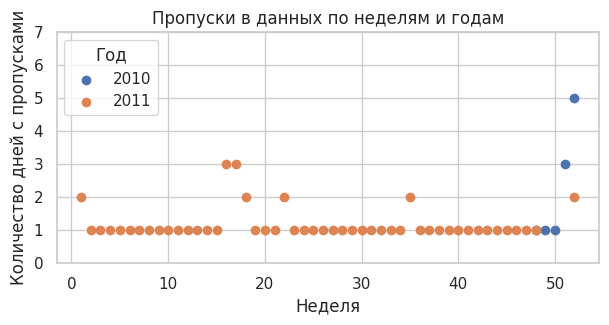

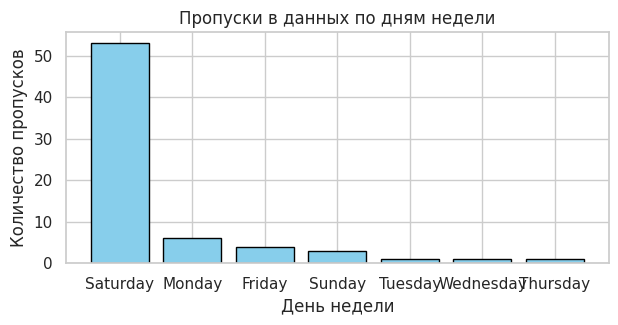

Подтвердилась гипотеза о пропусках на 51-52 неделях 2010г, а так же обнаружены частичные пропуски на 16-17 неделях 2011г.


In [28]:
# Визуализация пропусков дней в данных
visualize_missing_data(df_date_features)

print("Подтвердилась гипотеза о пропусках на 51-52 неделях 2010г, а так же обнаружены частичные пропуски на 16-17 неделях 2011г.")


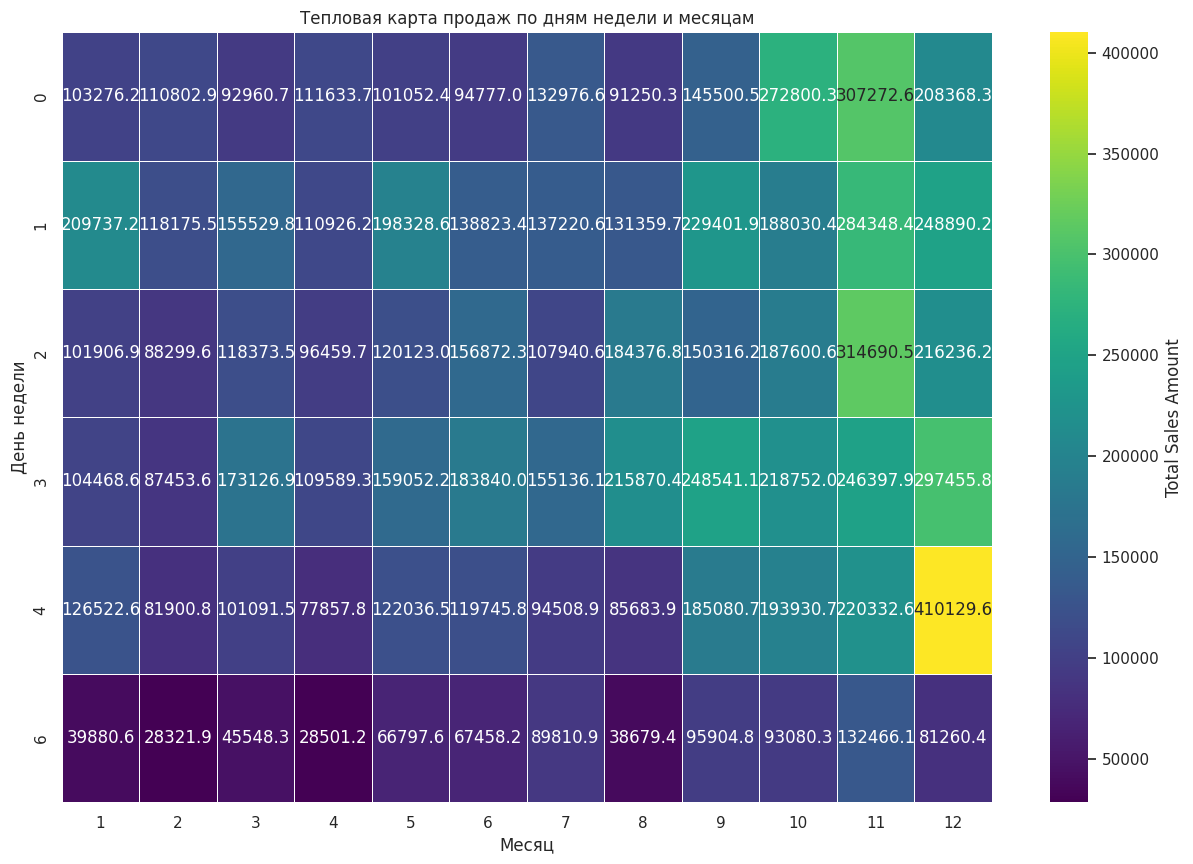

Самые 'тёплые' месяцы года - ноябрь и декабрь;
самый 'холодный' день недели - воскресенье.


In [29]:
# Импортируем функцию из модуля visualization
from Modules.visualization import plot_heatmap

# Визуализация: Тепловая карта продаж по дням недели и месяцам
plot_heatmap(df_date_features, 'Тепловая карта продаж по дням недели и месяцам', 'Месяц', 'День недели')

print("""Самые 'тёплые' месяцы года - ноябрь и декабрь;
самый 'холодный' день недели - воскресенье.""")

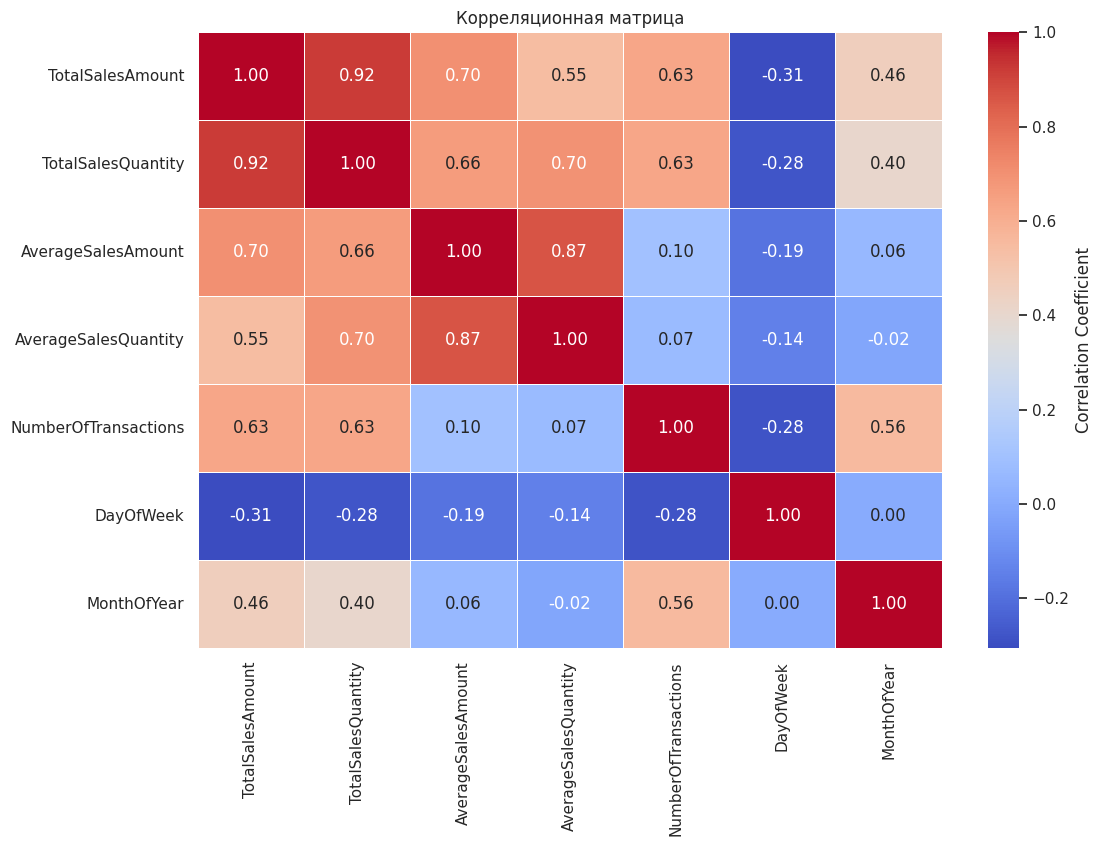

In [30]:
# Визуализация: Матрица корреляций
correlation_matrix(df_date_features)

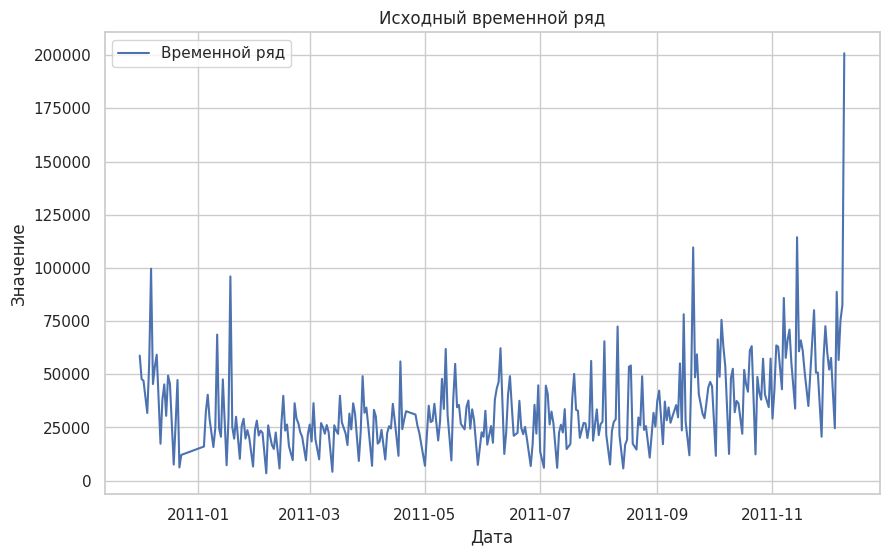

ADF Statistic: 0.10258155683771447
p-value: 0.9662369075925119

Временной ряд не является стационарным. Применим дифференцирование
ADF Statistic (после дифференцирования): -6.328418719664969
p-value (после дифференцирования): 2.947019423799566e-08

Результат ADF теста показывает, что после дифференцирования временной ряд стал стационарным


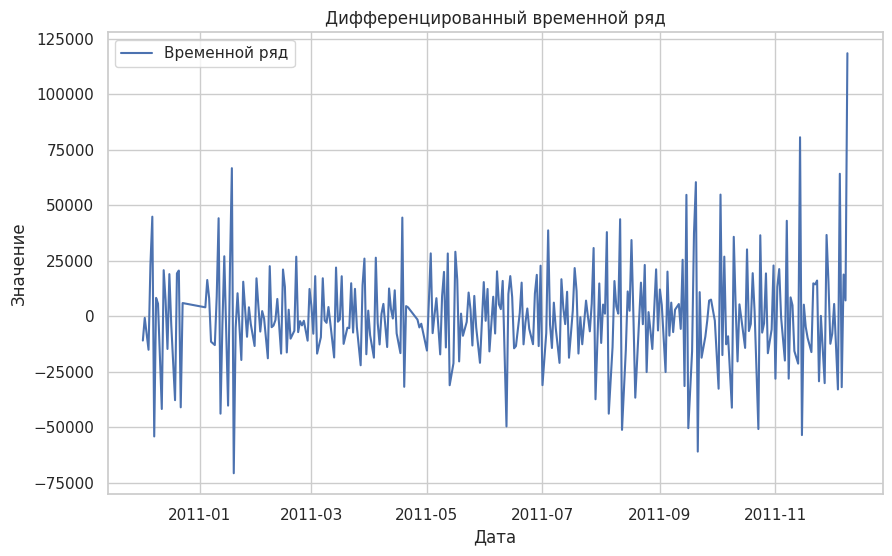

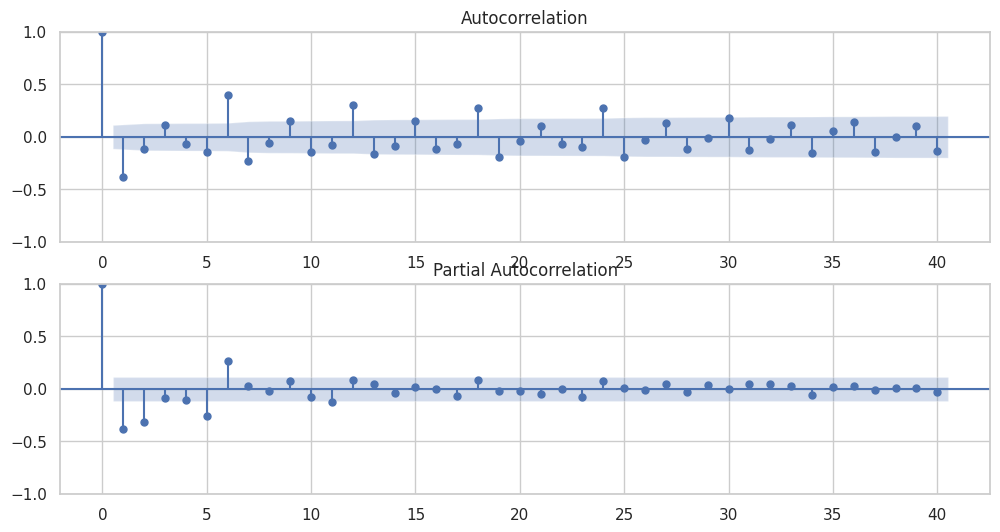

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       TotalSalesAmount   No. Observations:                  243
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2723.804
Date:                Thu, 20 Feb 2025   AIC                           5453.609
Time:                        02:58:29   BIC                           5464.075
Sample:                             0   HQIC                          5457.825
                                - 243                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3825      0.043     -8.924      0.000      -0.466      -0.298
ma.L1         -1.0000      0.068    -14.750      0.000      -1.133      -0.867
sigma2      3.425e+08   1.98e-10   1.73e+18      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


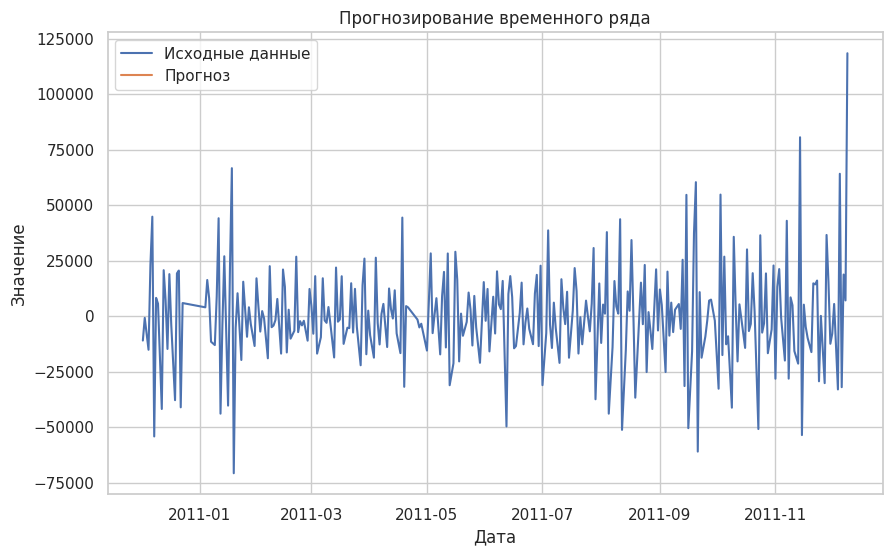

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Mean Squared Error: 2196385279.713749


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [55]:
import pandas as pd
from Modules.preprocessing import normalize_data, create_sequences
from Modules.visualization import visualize_time_series, visualize_residuals, visualize_forecast, visualize_residuals_test
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Использование существующего датасета df_date_features
ts = df_date_features[['Date', 'TotalSalesAmount']]
ts.set_index('Date', inplace=True)

# Задание частоты временного ряда
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D')  # Замените 'D' на вашу частоту (например, 'M' для месячных данных)

# Удаление пропущенных значений
ts = ts.dropna()

# Визуализация исходного временного ряда
visualize_time_series(ts, title='Исходный временной ряд')

# Проверка на стационарность с помощью ADF теста
result = adfuller(ts['TotalSalesAmount'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

print('\nВременной ряд не является стационарным. Применим дифференцирование')

# Если p-value > 0.05, временной ряд нестационарный
# Дифференцирование данных для достижения стационарности
ts_diff = ts.diff().dropna()

# Повторный тест ADF
result_diff = adfuller(ts_diff['TotalSalesAmount'])
print('ADF Statistic (после дифференцирования):', result_diff[0])
print('p-value (после дифференцирования):', result_diff[1])

print('\nРезультат ADF теста показывает, что после дифференцирования временной ряд стал стационарным')

# Визуализация дифференцированного временного ряда
visualize_time_series(ts_diff, title='Дифференцированный временной ряд')

# Визуализация автокорреляции и частичной автокорреляции
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(ts_diff['TotalSalesAmount'], ax=plt.gca(), lags=40)
plt.subplot(212)
plot_pacf(ts_diff['TotalSalesAmount'], ax=plt.gca(), lags=40)
plt.show()

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(ts_diff) * 0.8)
train_data, test_data = ts_diff[:train_size], ts_diff[train_size:]

# Обучение модели ARIMA
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Прогнозирование на тестовой выборке
forecast = model_fit.forecast(steps=len(test_data))
forecast_index = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='D')  # Замените 'D' на вашу частоту
forecast = pd.Series(forecast, index=forecast_index)
print(forecast)

# Визуализация прогноза
plt.figure(figsize=(10, 6))
plt.plot(ts_diff, label='Исходные данные')
plt.plot(forecast, label='Прогноз')
plt.title('Прогнозирование временного ряда')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Оценка модели
data_train = ts_diff.iloc[:-10]
data_test = ts_diff.iloc[-10:]
model = ARIMA(data_train, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=10)
mse = mean_squared_error(data_test, forecast)
print(f'Mean Squared Error: {mse}')


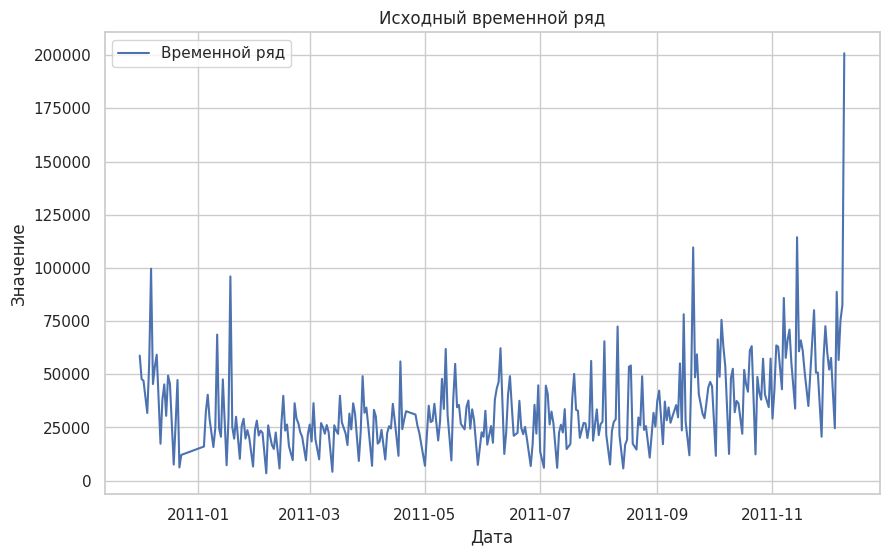

In [49]:
import pandas as pd
from Modules.preprocessing import normalize_data, create_sequences
from Modules.visualization import visualize_time_series, visualize_residuals, visualize_forecast, visualize_residuals_test
#from Modules.metrics import calculate_metrics, adf_test, ljung_box_test
#from Modules.modeling import arima_model, sarima_model, lstm_model, gru_model, cnn_model

# Использование существующего датасета df_date_features
ts = df_date_features[['Date', 'TotalSalesAmount']]
ts.set_index('Date', inplace=True)

# Задание частоты временного ряда
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D')  # Замените 'D' на вашу частоту (например, 'M' для месячных данных)

# Удаление пропущенных значений
ts = ts.dropna()

# Визуализация исходного временного ряда
visualize_time_series(ts, title='Исходный временной ряд')

In [50]:
from statsmodels.tsa.stattools import adfuller

# Проверка на стационарность с помощью ADF теста
result = adfuller(ts['TotalSalesAmount'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

print('\nВременной ряд не является стационарным. Применим дифференцие')

ADF Statistic: 0.10258155683771447
p-value: 0.9662369075925119

Временной ряд не является стационарным. Применим дифференцие


In [51]:
# Если p-value > 0.05, временной ряд нестационарный
# Дифференцирование данных для достижения стационарности
ts_diff = ts.diff().dropna()

# Повторный тест ADF
result_diff = adfuller(ts_diff['TotalSalesAmount'])
print('ADF Statistic (после дифференцирования):', result_diff[0])
print('p-value (после дифференцирования):', result_diff[1])

print('\nРезультат ADF теста показывает, что после дифференцирования временной ряд стал стационарным')

ADF Statistic (после дифференцирования): -6.328418719664969
p-value (после дифференцирования): 2.947019423799566e-08

Результат ADF теста показывает, что после дифференцирования временной ряд стал стационарным


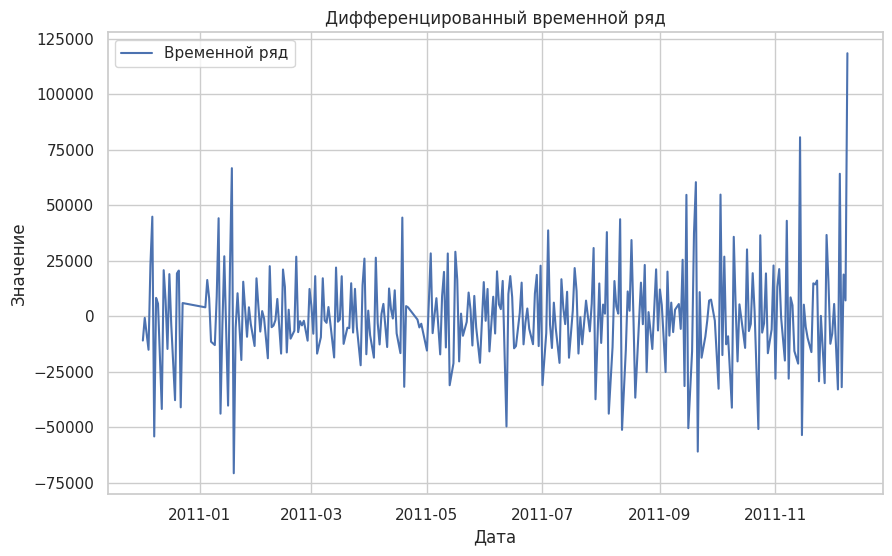

In [40]:
# Визуализация дифференцированного временного ряда
visualize_time_series(ts_diff, title='Дифференцированный временной ряд')

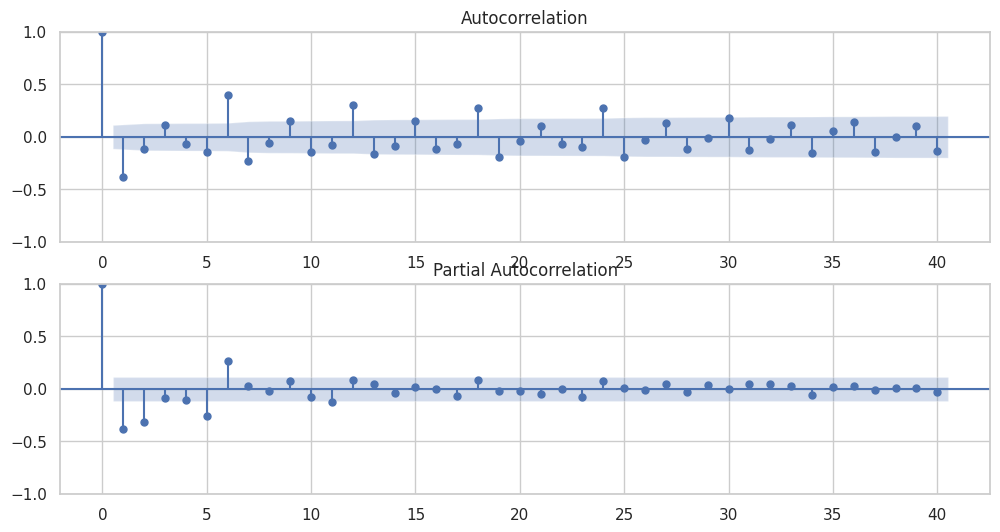

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Визуализация автокорреляции и частичной автокорреляции
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(ts_diff, ax=plt.gca(), lags=40)
plt.subplot(212)
plot_pacf(ts_diff, ax=plt.gca(), lags=40)
plt.show()

In [53]:
from statsmodels.tsa.arima.model import ARIMA

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(ts_diff) * 0.8)
train_data, test_data = ts_diff[:train_size], ts[train_size:]

# Обучение модели ARIMA
model = ARIMA(ts, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())
# Прогнозирование
forecast = model_fit.forecast(steps=10)
print(forecast)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       TotalSalesAmount   No. Observations:                  305
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3410.085
Date:                Thu, 20 Feb 2025   AIC                           6826.170
Time:                        02:52:06   BIC                           6837.321
Sample:                             0   HQIC                          6830.631
                                - 305                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0593      0.085      0.699      0.484      -0.107       0.226
ma.L1         -0.8977      0.039    -22.792      0.000      -0.975      -0.821
sigma2      3.639e+08   1.49e-10   2.44e+18      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


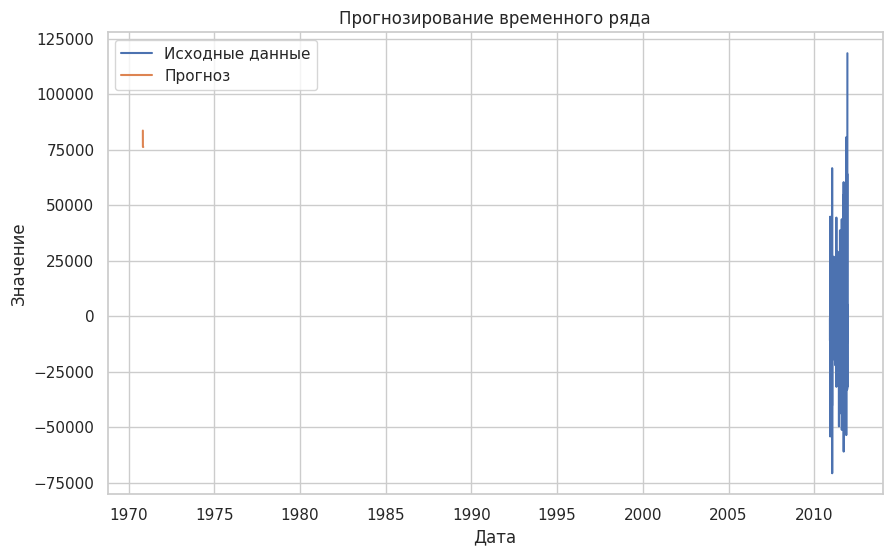

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

NameError: name 'mean_squared_error' is not defined

In [54]:
# Визуализация прогноза
plt.figure(figsize=(10, 6))
plt.plot(ts_diff, label='Исходные данные')
plt.plot(forecast, label='Прогноз')
plt.title('Прогнозирование временного ряда')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Оценка модели
data_train = ts_diff.iloc[:-10]
data_test = ts_diff.iloc[-10:]
model = ARIMA(data_train, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=10)
mse = mean_squared_error(data_test, forecast)
print(f'Mean Squared Error: {mse}')

In [56]:
!pip freeze > requirements.txt


In [57]:
from google.colab import files
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# Добавление всех изменений
!git add .

# Коммит изменений
!git commit -m "Сохранение изменений из Colab"

# Отправка изменений в ваш репозиторий на GitHub
!git push origin main

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@af99f2c1e8ef.(none)')
fatal: could not read Username for 'https://github.com': No such device or address
